In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from autorank import autorank,create_report,plot_stats
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    return pd.concat(df_collection,ignore_index=True)

df=load_priorband_data()

In [2]:
algo_dict={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
algo_dict["fig7"]=["random_search_prior","bo","pibo-default-first-10","bohb","priorband_bo"]
prior_dict={"good+bad":["at25","bad"]}
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","pibo-default-first-10":"PiBo","bohb":"BOHB","priorband_bo":"PriorBand+BO"}

for priortype in ["at25","bad"]:
    prior_dict[priortype]=[priortype]


df_dict={}
for prior_key,prior_value in prior_dict.items():
    df_dict[prior_key]={}
    for b_n,benchmark in enumerate(benchmarks):
        print(f"Prior {prior_key}, Benchmark {b_n+1}/{len(benchmarks)}      ", end="\r", flush=True)
        df_dict[prior_key][benchmark]={}
        for algo_key,algo_value in algo_dict.items():
            df_dict[prior_key][benchmark][algo_key]=df.loc[(df["prior"].isin(prior_value))&(df["algorithm"].isin(algo_value))&(df["benchmark"]==benchmark)].reset_index(drop=True)

In [3]:

def create_autorank_incumbent(priors:list[str],fs:list[float],algorithms:list[str],algo_group:str,benchmarks:list[str],df_dict:pd.DataFrame):
    output={}
    output["dataset"]={}
    output["mean_std"]={}
    for p_n,prior in enumerate(priors):
        output["dataset"][prior]={}
        output["mean_std"][prior]={}
        for f_n,max_f in enumerate(fs):
            output["dataset"][prior][max_f]={}
            labels=[]
            for algo in algorithms:
                labels.append(label_dict[algo])
            output["mean_std"][prior][max_f]=pd.DataFrame(columns=["benchmark"]+labels)
            for benchmark in benchmarks:
                output["dataset"][prior][max_f][benchmark]=pd.DataFrame()
                means_std=[]
                for algorithm in algorithms:
                    df_at_point=df_dict[prior][benchmark][algo_group].loc[df_dict[prior][benchmark][algo_group]["algorithm"]==algorithm]
                    df_at_point=df_at_point.loc[df_at_point["used_fidelity"]<=max_f]
                    column=[]
                    for seed in df_at_point["seed"].unique():
                        column.append(df_at_point.loc[df_at_point["seed"]==seed].iloc[-1]["value"])
                    output["dataset"][prior][max_f][benchmark][algorithm]=column
                    means_std.append(str(np.round(output["dataset"][prior][max_f][benchmark][algorithm].mean(),3))+" ± "+str(np.round(output["dataset"][prior][max_f][benchmark][algorithm].std(),3)))
                output["mean_std"][prior][max_f].loc[len(output["mean_std"][prior][max_f])]=[label_dict[benchmark]]+means_std
                print(f"Prior {prior} ({p_n+1}), Fidelity {f_n+1}/{len(fs)}          ", end="\r", flush=True)

    return (output["dataset"],output["mean_std"])

In [50]:
import warnings
warnings.filterwarnings("ignore","p-value may not be accurate for N > 5000.")
warnings.filterwarnings("ignore","Input data for shapiro has range zero. The results may not be accurate.")
warnings.filterwarnings("ignore","invalid value encountered in scalar divide")
warnings.filterwarnings("ignore","divide by zero encountered in log")

fig7={}
fig7["algo_group"]="fig7"
fig7["algorithms"]=algo_dict[fig7["algo_group"]].copy()
fig7["priors"]=["good+bad","at25","bad"]
fig7["benchmarks"]=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906"]
fig7["max_f"]=np.linspace(1,20,100)

fig7["dataset"]=create_autorank_incumbent(fig7["priors"],fig7["max_f"],fig7["algorithms"],fig7["algo_group"],fig7["benchmarks"],df_dict)[0]

resultframes={}
fig7["averages"]={}
fig7["sems"]={}
for p_n,prior in enumerate(fig7["priors"]):
    resultframes[prior]={}
    fig7["averages"][prior]={}
    fig7["sems"][prior]={}
    for f_n,max_f in enumerate(fig7["max_f"]):
        print(f"Prior {prior} ({p_n+1}), Fidelity {f_n+1}/{len(fig7['max_f'])}        ", end="\r", flush=True)
        resultframes[prior][max_f]={}
        for benchmark in fig7["benchmarks"]:
            resultframes[prior][max_f][benchmark]=autorank(fig7["dataset"][prior][max_f][benchmark])[0]

    for algo in fig7["algorithms"]:        
        fig7["averages"][prior][algo]=[(len(fig7["algorithms"])+1)/2]*2
        fig7["sems"][prior][algo]=[0]*2
        for max_f in fig7["max_f"]:
            ranks=[]
            for benchmark in fig7["benchmarks"]:
                ranks.append(len(fig7["algorithms"])+1-resultframes[prior][max_f][benchmark].loc[algo]["meanrank"])
            fig7["averages"][prior][algo].append(np.mean(ranks))
            fig7["sems"][prior][algo].append(stats.sem(ranks))

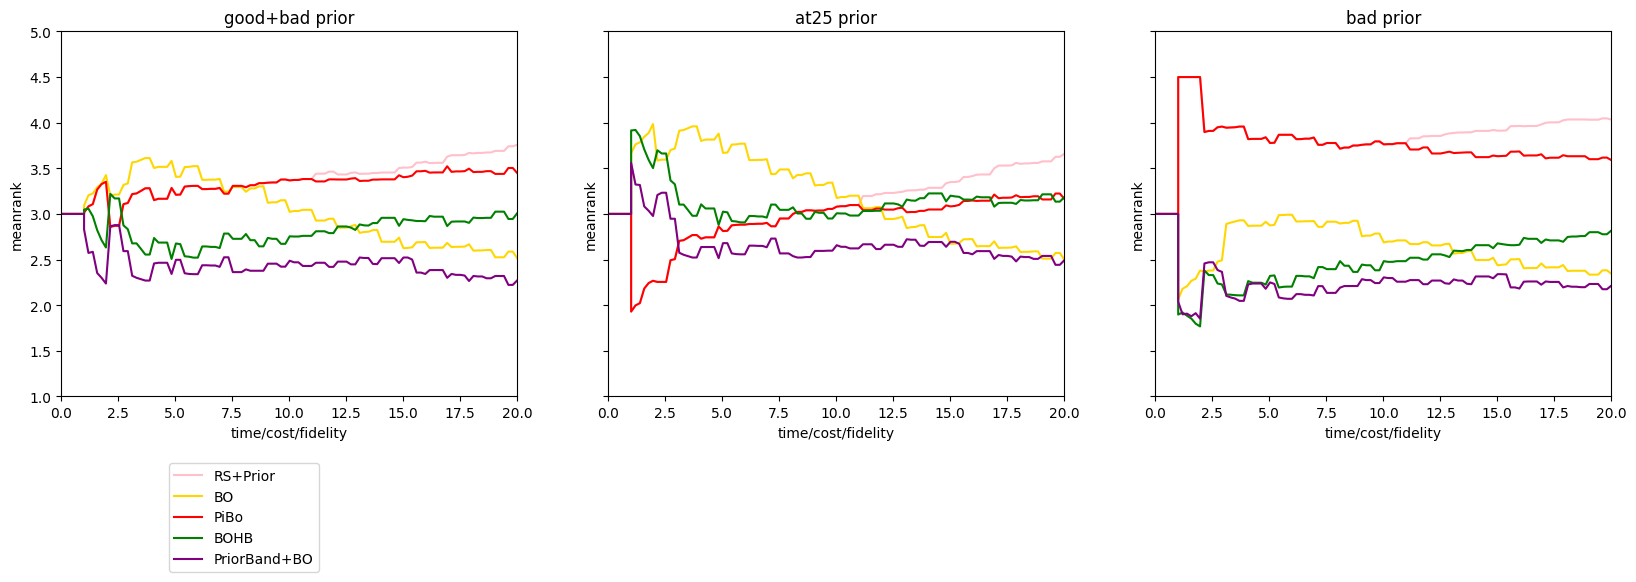

In [52]:
x_data=[0,1]+list(fig7["max_f"])
color_dict={"random_search_prior":"pink","bo":"gold","pibo":"red","pibo-default-first-10":"red","bohb":"green","priorband_bo":"purple"}


fig, axis = plt.subplots(ncols=len(fig7["priors"]),figsize=(20, 5),sharey=True)
for p_n,prior in enumerate(fig7["priors"]):
    for s_n,system in enumerate(fig7["algorithms"]):
        axis[p_n].errorbar(
            x_data,
            fig7["averages"][prior][system],
            #yerr=fig7["sems"][prior][system],
            fmt="-",
            label=label_dict[system],
            color=color_dict[system]
        )
    axis[p_n].set_xlabel("time/cost/fidelity")
    axis[p_n].set_ylim([1,len(fig7["algorithms"])])
    axis[p_n].set_xlim([0,20])
    axis[p_n].set_ylabel("meanrank")
    axis[p_n].set_title(f"{prior} prior")
legend = plt.legend(bbox_to_anchor=(-2, -0.5), loc='lower center')
plt.subplots_adjust(bottom=0.15)
plt.show()